In [1]:
import cuml
import cudf
import numpy as np
from collections import Counter
from cuml.cluster import HDBSCAN

/home/hice1/ltupac3/scratch/testpy/lib/python3.9/site-packages/cupy/_environment.py:541: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
# Load article vectors
file_path = "Word2Vec/retry/data/word2vec_financial_news_400_4.npy"
X_train = np.load(file_path)

print("Shape of embeddings:", X_train.shape)
X_cudf = cudf.DataFrame.from_records(X_train)

Shape of embeddings: (49845, 768)


In [3]:
hdb = cuml.cluster.hdbscan.HDBSCAN(
    min_cluster_size=50,
    min_samples=50,
    cluster_selection_method='eom',
    prediction_data=True
)
hdb.fit(X_cudf)

HDBSCAN()

In [4]:
import numpy as np
from collections import Counter

# Get labels from cuML HDBSCAN
labels = hdb.labels_.to_numpy()
cluster_counts = Counter(labels)

# Print sorted cluster sizes
for cluster_id, count in sorted(cluster_counts.items()):
    name = f"Cluster {cluster_id}" if cluster_id != -1 else "Noise (-1)"
    print(f"{name}: {count:,} articles")


Noise (-1): 37,379 articles
Cluster 0: 75 articles
Cluster 1: 303 articles
Cluster 2: 255 articles
Cluster 3: 178 articles
Cluster 4: 63 articles
Cluster 5: 154 articles
Cluster 6: 150 articles
Cluster 7: 154 articles
Cluster 8: 653 articles
Cluster 9: 118 articles
Cluster 10: 142 articles
Cluster 11: 269 articles
Cluster 12: 60 articles
Cluster 13: 111 articles
Cluster 14: 258 articles
Cluster 15: 369 articles
Cluster 16: 152 articles
Cluster 17: 141 articles
Cluster 18: 62 articles
Cluster 19: 256 articles
Cluster 20: 350 articles
Cluster 21: 225 articles
Cluster 22: 425 articles
Cluster 23: 244 articles
Cluster 24: 987 articles
Cluster 25: 551 articles
Cluster 26: 659 articles
Cluster 27: 120 articles
Cluster 28: 268 articles
Cluster 29: 839 articles
Cluster 30: 87 articles
Cluster 31: 84 articles
Cluster 32: 432 articles
Cluster 33: 69 articles
Cluster 34: 70 articles
Cluster 35: 52 articles
Cluster 36: 56 articles
Cluster 37: 84 articles
Cluster 38: 169 articles
Cluster 39: 364 ar

In [5]:
import pandas as pd

df_cluster_counts = pd.DataFrame.from_dict(cluster_counts, orient="index", columns=["count"])
df_cluster_counts.index.name = "cluster"
df_cluster_counts = df_cluster_counts.sort_values("count", ascending=False)
print(df_cluster_counts)


         count
cluster       
-1       37379
 24        987
 29        839
 26        659
 8         653
 49        613
 25        551
 48        481
 32        432
 22        425
 15        369
 39        364
 20        350
 1         303
 41        290
 11        269
 28        268
 14        258
 19        256
 2         255
 23        244
 40        243
 21        225
 3         178
 50        170
 38        169
 7         154
 5         154
 44        153
 16        152
 6         150
 10        142
 17        141
 45        136
 27        120
 9         118
 13        111
 47        105
 30         87
 43         85
 37         84
 31         84
 46         77
 0          75
 34         70
 33         69
 4          63
 18         62
 12         60
 36         56
 42         55
 35         52


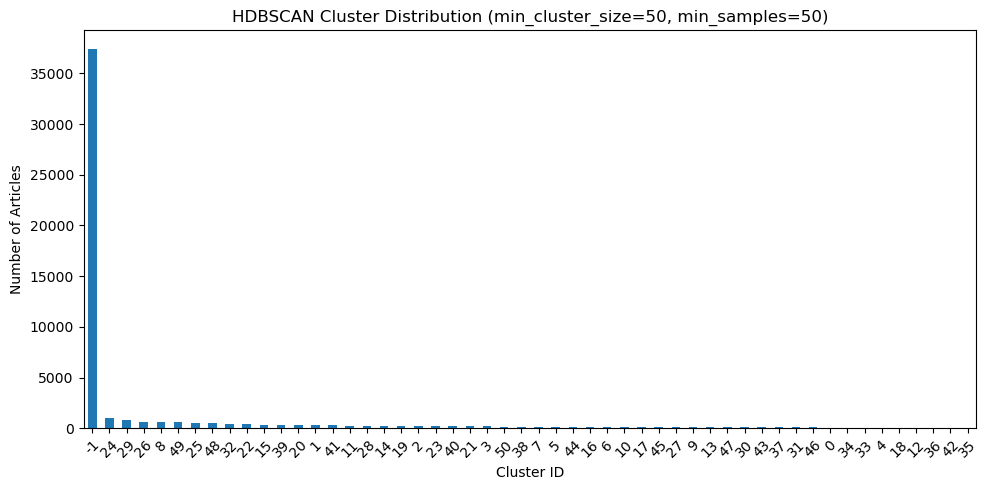

In [6]:
import matplotlib.pyplot as plt

df_cluster_counts.plot(kind="bar", figsize=(10, 5), legend=False)
plt.title("HDBSCAN Cluster Distribution (min_cluster_size=50, min_samples=50)")
plt.ylabel("Number of Articles")
plt.xlabel("Cluster ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Sub Cluster

In [7]:
# Get only vectors from Cluster 1
cluster_1_indices = np.where(labels == 1)[0]
X_cluster1 = X_train[cluster_1_indices]
other_indices = np.where(labels != 1)[0]

print("Sub-clustering", X_cluster1.shape[0], "articles from Cluster 1")
X_cluster1_cudf = cudf.DataFrame.from_records(X_cluster1)


Sub-clustering 303 articles from Cluster 1


In [8]:
hdb_sub = HDBSCAN(
    min_cluster_size=200, # or 150
    min_samples=200, # or 25 for lots of clusters
    cluster_selection_method="eom",
    prediction_data=True
)

hdb_sub.fit(X_cluster1_cudf)
sub_labels = hdb_sub.labels_.to_numpy()


counts = Counter(sub_labels)
print("Sub-Cluster Distribution (within Cluster 1):")
for cid, count in sorted(counts.items()):
    name = f"Cluster {cid}" if cid != -1 else "Noise (-1)"
    print(f"{name}: {count:,} articles")


Sub-Cluster Distribution (within Cluster 1):
Noise (-1): 303 articles


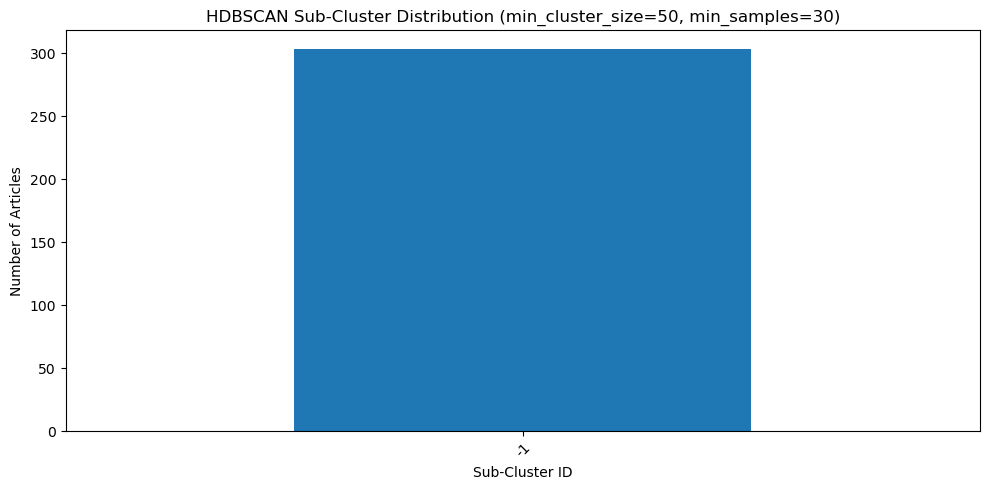

In [9]:
# plot sub-cluster distribution
df_sub_cluster_counts = pd.DataFrame.from_dict(counts, orient="index", columns=["count"])
df_sub_cluster_counts.index.name = "sub_cluster"
df_sub_cluster_counts = df_sub_cluster_counts.sort_values("count", ascending=False)

df_sub_cluster_counts.plot(kind="bar", figsize=(10, 5), legend=False)
plt.title("HDBSCAN Sub-Cluster Distribution (min_cluster_size=50, min_samples=30)")
plt.ylabel("Number of Articles")
plt.xlabel("Sub-Cluster ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
SUBCLUSTER_OFFSET = 10  # avoids collision
relabeled_subclusters = np.where(sub_labels == -1, -1, SUBCLUSTER_OFFSET + sub_labels)
relabeled_subclusters

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [11]:
Counter(labels[other_indices])

Counter({-1: 37379,
         24: 987,
         29: 839,
         26: 659,
         8: 653,
         49: 613,
         25: 551,
         48: 481,
         32: 432,
         22: 425,
         15: 369,
         39: 364,
         20: 350,
         41: 290,
         11: 269,
         28: 268,
         14: 258,
         19: 256,
         2: 255,
         23: 244,
         40: 243,
         21: 225,
         3: 178,
         50: 170,
         38: 169,
         5: 154,
         7: 154,
         44: 153,
         16: 152,
         6: 150,
         10: 142,
         17: 141,
         45: 136,
         27: 120,
         9: 118,
         13: 111,
         47: 105,
         30: 87,
         43: 85,
         31: 84,
         37: 84,
         46: 77,
         0: 75,
         34: 70,
         33: 69,
         4: 63,
         18: 62,
         12: 60,
         36: 56,
         42: 55,
         35: 52})

In [12]:
Counter(relabeled_subclusters)

Counter({-1: 303})

In [13]:
Counter(sub_labels)

Counter({-1: 303})

In [14]:
import numpy as np

# Initialize array with NaN or -1 (for non-cluster-1 points)
subcluster_labels_full = np.full_like(labels, fill_value=np.nan, dtype=float)

# Assign subcluster labels only to indices of Cluster 1
subcluster_labels_full[cluster_1_indices] = relabeled_subclusters
subcluster_labels_full[other_indices] = labels[other_indices]
# for cluster in subcluster_labels_full:
#     print(cluster)

In [15]:
Counter(subcluster_labels_full)

Counter({-1.0: 37682,
         24.0: 987,
         29.0: 839,
         26.0: 659,
         8.0: 653,
         49.0: 613,
         25.0: 551,
         48.0: 481,
         32.0: 432,
         22.0: 425,
         15.0: 369,
         39.0: 364,
         20.0: 350,
         41.0: 290,
         11.0: 269,
         28.0: 268,
         14.0: 258,
         19.0: 256,
         2.0: 255,
         23.0: 244,
         40.0: 243,
         21.0: 225,
         3.0: 178,
         50.0: 170,
         38.0: 169,
         5.0: 154,
         7.0: 154,
         44.0: 153,
         16.0: 152,
         6.0: 150,
         10.0: 142,
         17.0: 141,
         45.0: 136,
         27.0: 120,
         9.0: 118,
         13.0: 111,
         47.0: 105,
         30.0: 87,
         43.0: 85,
         31.0: 84,
         37.0: 84,
         46.0: 77,
         0.0: 75,
         34.0: 70,
         33.0: 69,
         4.0: 63,
         18.0: 62,
         12.0: 60,
         36.0: 56,
         42.0: 55,
         35.0: 52})

In [16]:
# save 
# np.save("Word2Vec/retry/data/hdbscan_cluster_subcluster_labels_full.npy", subcluster_labels_full)

# Subcluster, AGAIN

In [17]:
cluster_1_indices = np.where(subcluster_labels_full == 13)[0]
X_cluster1 = X_train[cluster_1_indices]
other_indices = np.where(subcluster_labels_full != 13)[0]

print("Sub-clustering", X_cluster1.shape[0], "articles from Cluster 13")
X_cluster1_cudf = cudf.DataFrame.from_records(X_cluster1)


Sub-clustering 111 articles from Cluster 13


In [18]:
import matplotlib.pyplot as plt
from collections import Counter

# Define parameter ranges to search over
min_cluster_sizes = [150, 200, 300]
min_samples_list = [25, 50, 100]

# Store results
results = []

for mcs in min_cluster_sizes:
    for ms in min_samples_list:
        print(f"Trying min_cluster_size={mcs}, min_samples={ms}")
        
        hdb = HDBSCAN(
            min_cluster_size=mcs,
            min_samples=ms,
            cluster_selection_method="eom",
            prediction_data=True
        )
        
        hdb.fit(X_cluster1_cudf)
        labels = hdb.labels_.to_numpy()
        distribution = Counter(labels)
        biggest_cluster = max(distribution.values())
        results.append((mcs, ms, len(labels), biggest_cluster))
        print("biggest cluster:", biggest_cluster)
        print("label length:", len(labels))


Trying min_cluster_size=150, min_samples=25


biggest cluster: 111
label length: 111
Trying min_cluster_size=150, min_samples=50
biggest cluster: 111
label length: 111
Trying min_cluster_size=150, min_samples=100
biggest cluster: 111
label length: 111
Trying min_cluster_size=200, min_samples=25
biggest cluster: 111
label length: 111
Trying min_cluster_size=200, min_samples=50
biggest cluster: 111
label length: 111
Trying min_cluster_size=200, min_samples=100
biggest cluster: 111
label length: 111
Trying min_cluster_size=300, min_samples=25
biggest cluster: 111
label length: 111
Trying min_cluster_size=300, min_samples=50
biggest cluster: 111
label length: 111
Trying min_cluster_size=300, min_samples=100
biggest cluster: 111
label length: 111


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results, columns=["min_cluster_size", "min_samples", "total_points", "biggest_cluster"])

df_results.head()

,min_cluster_size,min_samples,total_points,biggest_cluster
0,150,25,111,111
1,150,50,111,111
2,150,100,111,111
3,200,25,111,111
4,200,50,111,111
